# 모델에 대한 설명1 : Partial Dependence Plot



## 1.환경준비

### 1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, SVR

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.backend import clear_session

### 2) 데이터 로딩

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/DA4BAM/dataset/master/boston.csv')
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


* 변수 설명
    * crim : 범죄율
    * zn : 대저택 비율
    * indus : 상업지역 비율
    * chas : 찰스 강변 여부
    * nox : 일산화질소 농도(공기오염도)
    * rm : 평균 주택당 방 수
    * age : 30년 이상된 주택 비율
    * dis : 주요 업무 지역 접근성 지수
    * rad : 고속도로 접근성 지수
    * tax  1만 달러당 재산세
    * ptratio : 교사1명당 학생수
    * lstat : 하위계층 비율
    * black : 흑인비율(원래 숫자를 변형한 것임)
    * mdev : 타운별 집값 중위수(단위 : 1000달러)

### 3) 필요한 함수 생성

In [3]:
# 변수 중요도 plot
def plot_feature_importance(importance, names, topn = 'all'):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('importance')
    plt.ylabel('feature names')
    plt.grid()

    return fi_df

## 2.데이터 준비


### 1) x, y로 나누기 

In [4]:
target = 'medv'
x = data.drop(target, axis = 1)
y = data.loc[:,target]

### 2) 가변수화

### 3) train : validation 분할

In [5]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .2, random_state = 20)
x_train.shape

(404, 13)

## 3.Partial Dependence Plot(PDP)

### 1) 모델생성
* RandomForest 모델을 만들고 개별 데이터 분석 단위에 대해서 해석해 보겠습니다.

In [6]:
from sklearn.ensemble import RandomForestRegressor

In [7]:
model = RandomForestRegressor()
model.fit(x_train, y_train)

RandomForestRegressor()

### 2) PDP

In [8]:
from sklearn.inspection import plot_partial_dependence, partial_dependence

* PDP 그리기
    * model : 이미 만든 모델
    * features : 분석할 대상 feature
    * X : 데이터셋(x)
    * kind : 'both' ➡ plotting both Partial dependence (PD) and individual conditional expectation (ICE)

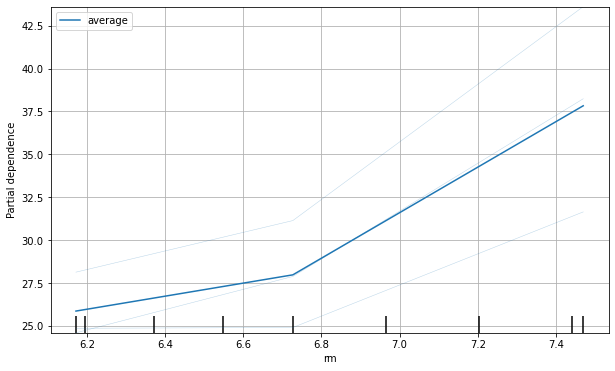

In [9]:
var = 'rm'
temp = x_train.head(3).copy()

plt.rcParams['figure.figsize'] = 10, 6
plot_partial_dependence(model, features = [var], X = temp, kind = 'both')
plt.grid()
plt.show()

In [10]:
temp

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311,15.2,396.9,19.15
268,0.54050,20.0,3.97,0,0.575,7.470,52.6,2.8720,5,264,13.0,390.3,3.16
80,0.04113,25.0,4.86,0,0.426,6.727,33.5,5.4007,4,281,19.0,396.9,5.29


In [11]:
# temp = x_train.head(5)
pdp = partial_dependence(model, features = [var], X = temp, kind = 'both')
print(pdp['average'])
print(pdp['individual'])
print(pdp['values'])

[[25.863 27.975 37.832]]
[[[24.861 24.905 31.644]
  [28.132 31.139 43.612]
  [24.596 27.881 38.24 ]]]
[array([6.172, 6.727, 7.47 ])]


* 수동으로 만들기


In [12]:
temp['rm'] = 6.172
temp
model.predict(temp)

array([24.861, 28.132, 24.596])

* 전체 데이터에 대해서 살펴봅시다.

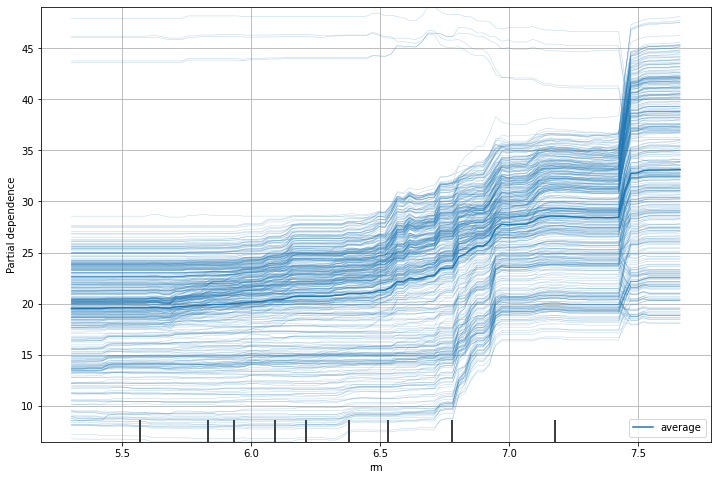

In [13]:
plt.rcParams['figure.figsize'] = 12, 8
plot_partial_dependence(model, 
                        features = [var], 
                        X = x_train, 
                        kind = 'both')
plt.grid()
plt.show()

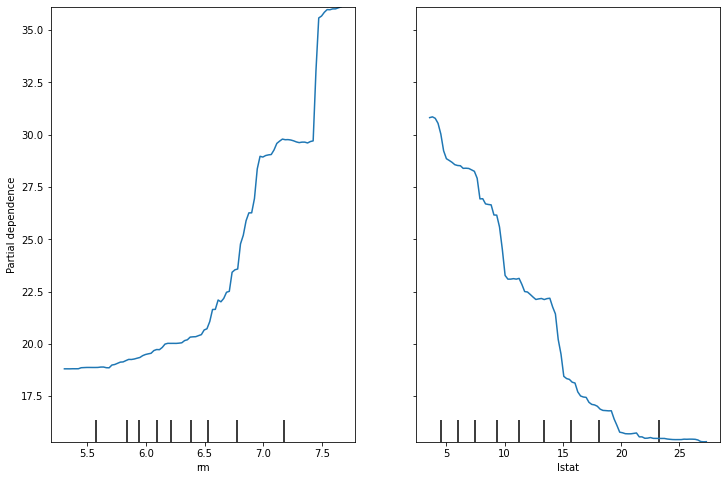

In [14]:
plot_partial_dependence(model, features = ['rm','lstat'], X = x_train)
plt.show()

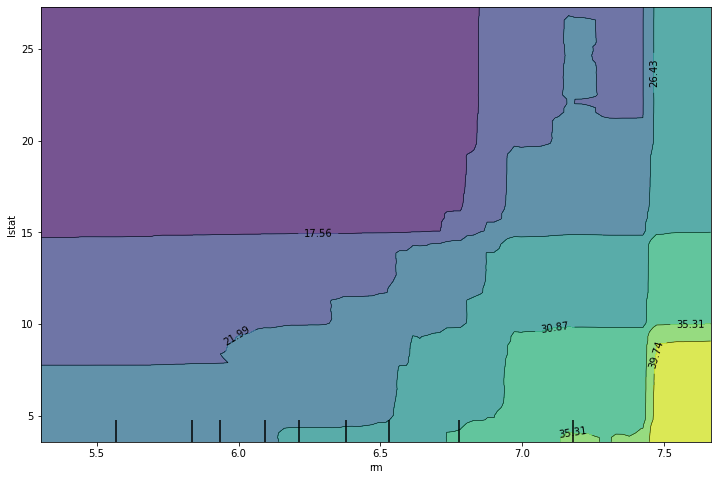

In [15]:
plot_partial_dependence(model, features = [('rm','lstat')], X = x_train)
plt.show()

## 4.실습 : 특정 feature 값의 변화에 따른 예측값 영향 분석

### 1) 데이터 준비

* 데이터 로딩

In [16]:
# data data
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/Attrition2.csv"
data = pd.read_csv(path)
data.head(10)

,Attrition,Age,Department,DistanceFromHome,Education,EducationField,Gender,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,RelationshipSatisfaction,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany
0,0,28,Research & Development,1,3,Medical,Female,Research Scientist,1,Married,3591,1,3,3,3,3,3
1,1,37,Research & Development,2,2,Other,Male,Laboratory Technician,3,Single,2090,6,2,7,3,3,0
2,0,27,Research & Development,8,5,Life Sciences,Male,Laboratory Technician,3,Married,4621,1,4,3,4,3,3
3,0,18,Research & Development,1,3,Life Sciences,Female,Laboratory Technician,4,Single,1611,1,3,0,5,4,0
4,0,29,Research & Development,9,3,Life Sciences,Male,Research Scientist,3,Married,2451,6,1,5,2,2,1
5,0,44,Research & Development,2,1,Medical,Male,Manufacturing Director,3,Single,10209,5,2,16,2,2,2
6,0,41,Sales,10,2,Life Sciences,Male,Sales Executive,4,Single,6230,7,4,16,3,3,14
7,0,25,Sales,18,1,Life Sciences,Male,Sales Executive,3,Married,6232,2,2,6,3,2,3
8,0,50,Research & Development,2,3,Medical,Male,Research Director,3,Married,17639,5,4,30,3,3,4
9,0,47,Sales,4,2,Life Sciences,Female,Sales Executive,4,Single,4163,1,3,9,0,3,9


|	변수 명	|	내용	|	구분	|
|	----	|	----	|	----	|
|	**Attrition**	|	이직여부, Yes = 1 , No = 0	|	**Target**	|
|	Age	|	나이	|	숫자	|
|	BusinessTravel	|	출장 빈도(범주)	|		|
|	Department	|	현 부서	|		|
|	DistanceFromHome	|	집-직장 거리(마일)	|	숫자	|
|	Education	|	교육수준(범주)	|	1 Below College, 2 College, 3 Bachelor, 4 Master, 5 Doctor	|
|	EducationField	|	전공	|		|
|	EnvironmentSatisfaction	|	근무환경에 대한 만족도(범주)	|	1 Low, 2 Good, 3 Excellent, 4 Outstanding	|
|	Gender	|	성별	|		|
|	JobInvolvement	|	직무 적극성(참여도)	|	1 Low, 2 Medium, 3 High, 4 Very High	|
|	JobRole	|	직무	|		|
|	JobSatisfaction	|	직무 만족도	|	1 Low, 2 Medium, 3 High, 4 Very High	|
|	MaritalStatus	|	결혼상태	|		|
|	MonthlyIncome	|	월급	|	숫자	|
|	NumCompaniesWorked	|	현재까지 근무한 회사 수	|	숫자	|
|	PercentSalaryHike	|	전년대비 급여인상율(%)	|	숫자	|
|	RelationshipSatisfaction	|	동료와의 관계 만족도	|	1 Low, 2 Medium, 3 High, 4 Very High	|
|	StockOptionLevel	|	스톡옵션 수준 0~3	|	범주	|
|	TotalWorkingYears	|	총 근무 연수	|	숫자	|
|	TrainingTimesLastYear	|	전년 교육훈련 횟수	|	숫자	|
|	WorkLifeBalance	|	워라밸. 일-삶 균형도	|	1 Bad, 2 Good, 3 Better, 4 Best	|
|	YearsAtCompany	|	현직장 근무 연수	|	숫자	|
|	YearsInCurrentRole	|	현직무 연수	|	숫자	|
|	YearsWithCurrManager	|	현 팀장과 근무한 연수	|	숫자	|


In [17]:
target = 'Attrition'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

In [18]:
y.value_counts() / y.shape[0]

0    0.913043
1    0.086957
Name: Attrition, dtype: float64

* 가변수화 Dummy Variable

In [19]:
dummy_vars = ['Education','Department','EducationField','Gender','JobRole','MaritalStatus'] 
x = pd.get_dummies(x, columns = dummy_vars, drop_first=True) 

* 데이터 분할
    * 이미 test set은 분할되어 있다고 가정합니다.
    * 주어진 데이터를 train set : validation set 으로 분할

In [20]:
# train_val에서 train : val = 8 : 2
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state = 2022)

In [21]:
print(x_train.shape, x_val.shape)

(920, 32) (230, 32)


* class balance를 맞추기 위한 resampling

In [22]:
from imblearn.over_sampling import SMOTE

In [23]:
smote = SMOTE()
x_train, y_train = smote.fit_resample(x_train, y_train)

### 2) 모델링

* model : RandomForest, xgb, svm 등...

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [25]:
model = RandomForestClassifier()
model.fit(x_train, y_train)

RandomForestClassifier()

### 3) PDP

* model : 이미 만든 모델
* features : 아래 변수들에 대해 분석을 시도하시오.
* X : x_val
* kind
    * kind='average' results in the traditional PD plot(default)
    * kind='individual' results in the ICE plot
    * kind='both' results in plotting both the ICE and PD on the same plot.

In [26]:
from sklearn.inspection import plot_partial_dependence, partial_dependence

#### ① 개별 변수 분석

* 중요한 feature 각각에 대해서 PDP를 그리고 해석해 보겠습니다.
    * kind 옵션 없이 그래프 그리기
    * kind = 'both'로 그래프 그리기

* feature 1 : MonthlyIncome

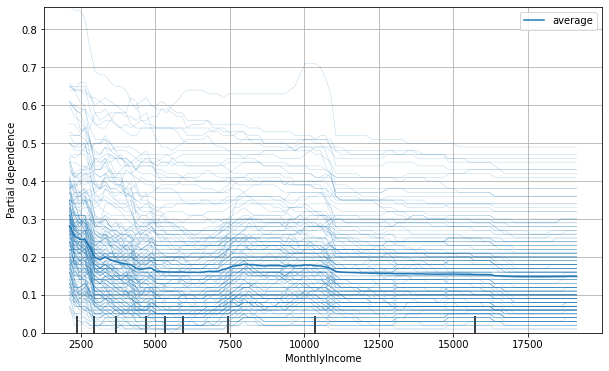

In [37]:
var = 'MonthlyIncome'

plot_partial_dependence(model, features = [var], X = x_val, kind = 'both')
plt.grid()
plt.show()

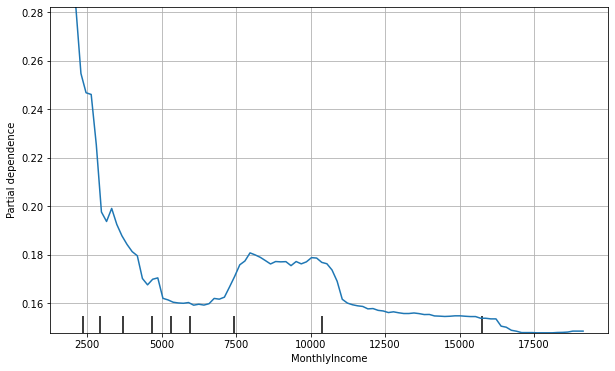

In [38]:
var = 'MonthlyIncome'

plot_partial_dependence(model, features = [var], X = x_val, kind = 'average')
plt.grid()
plt.show()

* feature 2 : MaritalStatus_Married

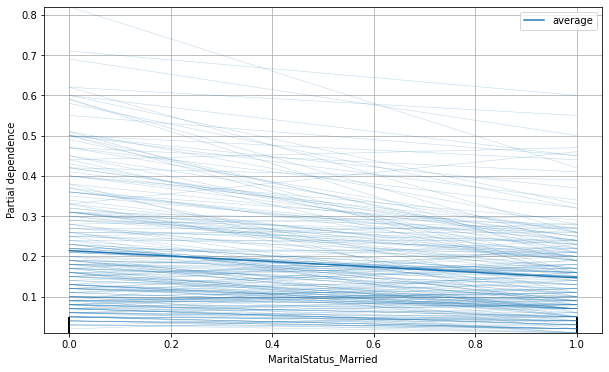

In [39]:
var = 'MaritalStatus_Married'
temp = x_train.head(3).copy()

plt.rcParams['figure.figsize'] = 10,6
plot_partial_dependence(model, features = [var], X = x_val, kind = 'both')
plt.grid()
plt.show()

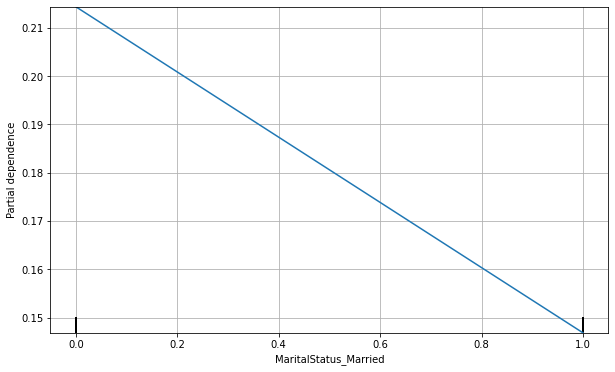

In [46]:
var = 'MaritalStatus_Married'
plt.rcParams['figure.figsize'] = 10,6
plot_partial_dependence(model, features = [var], X = x_val, kind = 'average')
plt.grid()
plt.show()

* feature 3 : DistanceFromHome

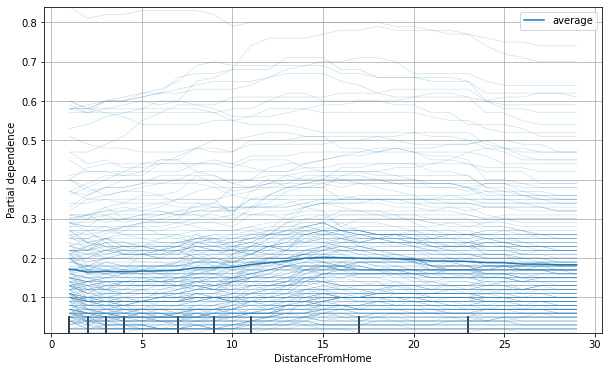

In [40]:
var = 'DistanceFromHome'
temp = x_train.head(3).copy()

plt.rcParams['figure.figsize'] = 10,6
plot_partial_dependence(model, features = [var], X = x_val, kind = 'both')
plt.grid()
plt.show()

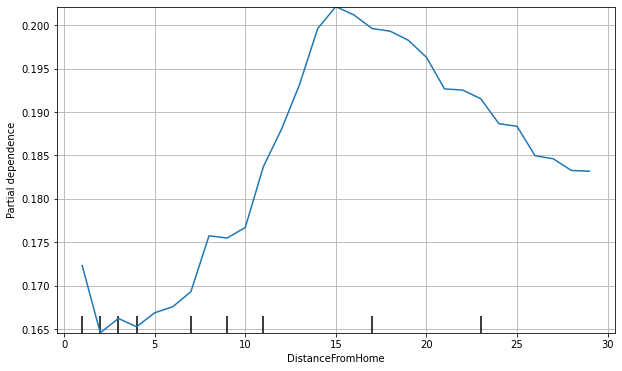

In [47]:
var = 'DistanceFromHome'
plt.rcParams['figure.figsize'] = 10,6
plot_partial_dependence(model, features = [var], X = x_val, kind = 'average')
plt.grid()
plt.show()

* feature 4 : JobSatisfaction

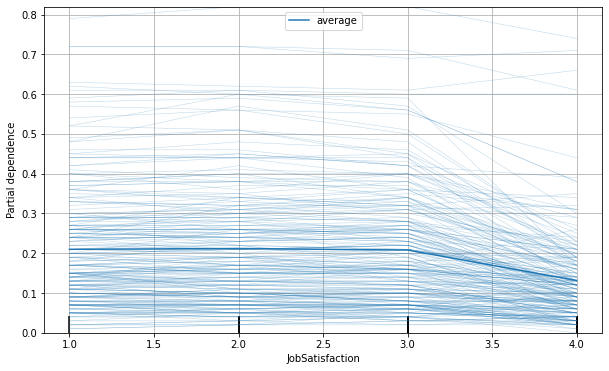

In [41]:
var = 'JobSatisfaction'
temp = x_train.head(3).copy()

plt.rcParams['figure.figsize'] = 10,6
plot_partial_dependence(model, features = [var], X = x_val, kind = 'both')
plt.grid()
plt.show()

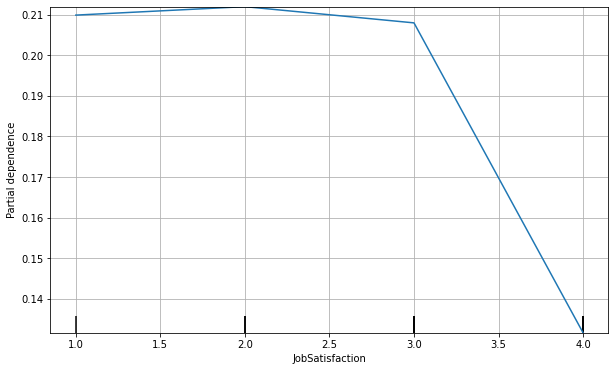

In [48]:
var = 'JobSatisfaction'
plt.rcParams['figure.figsize'] = 10,6
plot_partial_dependence(model, features = [var], X = x_val, kind = 'average')
plt.grid()
plt.show()

#### ② 두 변수와 예측값 비교
* 두 변수의 조합으로 예측값과의 관계를 살펴봅시다.


* 조합1

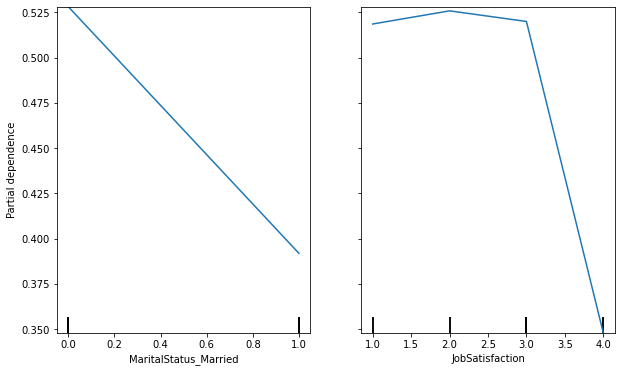

In [35]:
plot_partial_dependence(model, features = ['MaritalStatus_Married','JobSatisfaction'], X = x_train)
plt.show()

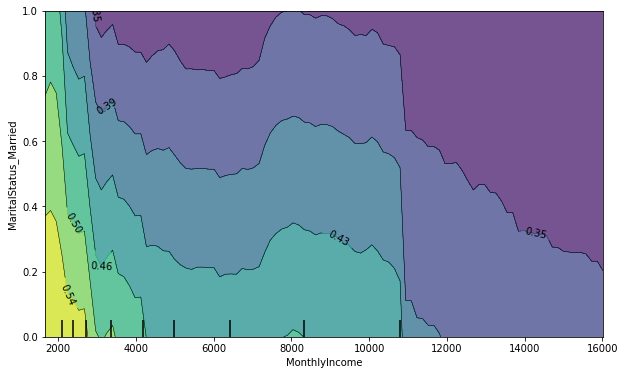

In [50]:
plot_partial_dependence(model, features = [('MonthlyIncome','MaritalStatus_Married')], X = x_train)
plt.show()

* 조합2